In [1]:
%%capture --no-stderr
%pip install -U -q langgraph langsmith langchain_xai pokerkit python-dotenv pillow

# Building a Poker Hand Analysis Agent with LangGraph

This notebook demonstrates how to build an intelligent poker hand analysis agent using LangGraph and the Grok API. We'll create a system that can:

1. Analyze poker hand strength using Monte Carlo simulations
2. Provide strategic decision-making advice at different stages of a poker game
3. Process visual information from images of poker hands (optionally)

The notebook follows a progressive approach, starting with simple concepts and building towards a complete solution.

**Date**: April 2025  
**Technologies**: LangGraph, LangChain, PokerKit, XAI

In [2]:
import os 
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()

# Retrieve API key from environment variables
grok_api_key = os.getenv("GROK_API_KEY")

# Verify API key is available
if not grok_api_key:
    raise ValueError("GROK_API_KEY not found. Please set it in your .env file.")

## 1. Building a Basic Chatbot with LangGraph

LangGraph is a powerful framework for building agents as graphs. Before we dive into poker analysis, let's understand the fundamentals by building a simple chatbot.

### What is a StateGraph?

A StateGraph represents our agent as a state machine where:
- **Nodes** are functions or operations the agent can perform (like generating responses or using tools)
- **Edges** define how the agent transitions between these functions
- **State** maintains information throughout the conversation

This approach allows us to create complex, multi-step reasoning flows with more control than simple chains.

In [3]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

# Define our State structure
class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]

# Initialize a new StateGraph with our State definition
graph_builder = StateGraph(State)

### Setting Up the LLM

For our chatbot, we'll use the Grok-2-vision model which can process both text and images - useful for our poker application later.

In [4]:
from langchain_xai import ChatXAI

# Initialize the Grok model with vision capabilities
llm = ChatXAI(api_key=grok_api_key,
              model='grok-2-vision-1212')

# Define the chatbot function that will process state and generate responses
def chatbot(state: State):
    # The function receives the current state and returns an updated state
    # with the model's response appended to messages
    return {"messages": [llm.invoke(state["messages"])]}

# Add the chatbot node to our graph
graph_builder.add_node("chatbot", chatbot)

### Defining the Graph Flow

Now we'll establish how our graph should execute by setting entry and exit points.

In [5]:
# Define the starting point - all execution begins at the chatbot node
graph_builder.add_edge(START, "chatbot")

# Define the ending point - after the chatbot generates a response, execution can finish
graph_builder.add_edge("chatbot", END)

# Compile the graph into an executable form
graph = graph_builder.compile()

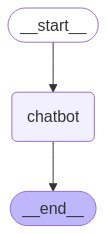

In [6]:
from IPython.display import Image, display

try:
    # Visualize the graph structure for better understanding
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    print("Graph visualization requires additional dependencies (graphviz).")
    print("You can install them with: pip install graphviz")

## 2. Enhancing the Chatbot with Poker Tools

Now let's make our agent more powerful by adding poker analysis capabilities. We'll build tools that can calculate hand strength and provide strategic advice.

### Understanding Poker Hand Analysis

Poker hand strength is typically evaluated in two ways:
1. **Absolute hand strength**: How strong your hand is based on poker hand rankings
2. **Relative hand strength**: The probability your hand will win against opponents' likely holdings

We'll use Monte Carlo simulations to estimate hand strength by repeatedly simulating random scenarios. This approach:
- Generates many random opponent hands and board completions
- Evaluates the win/loss outcomes across these simulations
- Calculates a probability of winning (hand strength)

In [7]:
from concurrent.futures import ProcessPoolExecutor
from pokerkit import *

# Example hand strength calculation
def example_hand_strength():
    with ProcessPoolExecutor() as executor:
        result = calculate_hand_strength(
            player_count = 2,                    # Two players: you vs opponent
            hole_range = parse_range('2sTh'),    # Your hole cards: 2 of spades, 10 of hearts
            board_cards = Card.parse('Kc8h8d'),  # Board: King of clubs, 8 of hearts, 8 of diamonds
            hole_dealing_count = 2,              # Standard 2 hole cards per player
            board_dealing_count = 5,             # Final board size in Texas Hold'em
            deck = Deck.STANDARD,                # Standard 52-card deck
            hand_types = (StandardHighHand,),    # Texas Hold'em high hand evaluation
            sample_count=1000,                   # Number of Monte Carlo simulations
            executor=executor,                   # For parallel computation
        )
    return result

# Note: Uncomment to run this example
# print("Example hand strength:", example_hand_strength())

### Creating a Hand Strength Tool

Now let's create a properly structured tool that our agent can use to calculate hand strength.

In [8]:
from concurrent.futures import ProcessPoolExecutor
from pokerkit import calculate_hand_strength, parse_range, Card, Deck, StandardHighHand
from langchain_core.tools import tool
from typing import Optional
from langgraph.prebuilt import ToolNode

@tool
def get_hand_strength(hole_range: str, board_cards: Optional[str] = '') -> float:
    """
    Compute a player's hand strength in Texas Hold'em poker using Monte Carlo simulation.

    Args:
        hole_range (str): The player's hole cards or range (e.g., 'AsKs' for Ace-King suited, 
                          'AK' for all AK combos). Uses standard poker notation: 
                          2-9, T(for 10), J, Q, K, A for ranks; Rank are in Capital letter
                          s (spades), h (hearts), d (diamonds), c (clubs) for suits, which are in lower case.
        board_cards (str, optional): Community cards on the board (e.g., 'Kc8h8d' for King of clubs, 
                                     8 of hearts, 8 of diamonds). Defaults to empty string (preflop scenario).

    Returns:
        float: Hand strength between 0 and 1, where closer to 1 indicates a stronger hand 
               (probability of beating a random opponent's hand).

    Raises:
        ValueError: If hole_range or board_cards are invalid or malformed.
    """
    try:
        # Parse hole range and board cards
        parsed_hole_range = parse_range(hole_range)
        parsed_board_cards = Card.parse(board_cards) if board_cards else ('')

        # Use ProcessPoolExecutor for parallel computation
        with ProcessPoolExecutor() as executor:
            result = calculate_hand_strength(
                player_count=2,                # Two players: user vs. random opponent
                hole_range=parsed_hole_range,  # Parsed hole cards/range
                board_cards=parsed_board_cards,# Parsed board cards (empty if preflop)
                hole_dealing_count=2,          # Standard 2 hole cards per player
                board_dealing_count=5,         # Final board size (Texas Hold'em)
                deck=Deck.STANDARD,            # Standard 52-card deck
                hand_types=(StandardHighHand,),# Texas Hold'em hand evaluation
                sample_count=1000,             # Monte Carlo simulation iterations
                executor=executor              # Parallel execution
            )
        
        # Ensure result is between 0 and 1
        return float(result)

    except Exception as e:
        raise ValueError(f"Error calculating hand strength: {str(e)}")

In [9]:
# Create a collection of tools and instantiate a ToolNode
tools = [get_hand_strength]
tool_node = ToolNode(tools)

## 3. Building a ReAct Agent for Poker Analysis

Now we'll create a more sophisticated agent that can:
1. Process user queries about poker hands
2. Reason about what tools it needs to use
3. Call the hand strength tool to get numerical data
4. Formulate recommendations based on the analysis

This follows the ReAct pattern (Reasoning + Acting) where the agent alternates between reasoning about what to do and taking actions.

In [10]:
# Add our hand strength tool to the LLM
model_with_tools = ChatXAI(
    model="grok-2-vision-1212",
    api_key=grok_api_key
).bind_tools(tools)

### Creating the Workflow Graph

Our ReAct agent workflow will cycle between:
1. The LLM deciding what to do (reasoning)
2. Calling tools when needed (acting)
3. Receiving tool results and continuing the reasoning process

In [11]:
from typing import Literal
from langgraph.graph import StateGraph, MessagesState, START, END

# This function determines whether the agent should continue processing or finish
def should_continue(state: MessagesState):
    messages = state["messages"]
    last_message = messages[-1]
    
    # If the last message contains tool calls, route to the tools node
    if last_message.tool_calls:
        return "tools"
    # Otherwise, end the workflow
    return END

# This function calls the LLM with the current messages
def call_model(state: MessagesState):
    messages = state["messages"]
    response = model_with_tools.invoke(messages)
    return {"messages": [response]}

# Create a new StateGraph with MessagesState (a predefined state type for chat)
workflow = StateGraph(MessagesState)

# Add the two nodes we'll cycle between
workflow.add_node("agent", call_model)  # For reasoning
workflow.add_node("tools", tool_node)   # For acting

# Define the graph flow
workflow.add_edge(START, "agent")  # Always start with the agent reasoning
workflow.add_conditional_edges(
    "agent",                # From the agent node
    should_continue,        # Use this function to decide where to go next
    ["tools", END]          # Potential destinations: tools or end
)
workflow.add_edge("tools", "agent")  # After using tools, go back to the agent

# Compile the workflow into an executable application
app = workflow.compile()

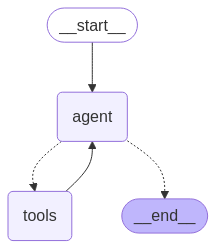

In [12]:
from IPython.display import Image, display

try:
    # Visualize the ReAct agent workflow
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    print("Graph visualization requires additional dependencies (graphviz).")

## 4. Processing Poker Hand Images (Optional)

Let's enhance our agent to analyze poker hands from images. This is useful for players who want to analyze real game situations from screenshots or photos.

### Best Practices for Image Processing

When sending images to an LLM, it's important to:
1. Resize large images to reduce bandwidth and processing requirements
2. Ensure the image is clear enough for the model to interpret card values and suits
3. Use efficient base64 encoding to include the image in messages

In [13]:
import base64
from PIL import Image as PILImage
import io

def process_image_for_llm(image_path, max_size=(800, 800)):
    """
    Process an image for sending to an LLM:
    1. Resize if too large
    2. Convert to base64 encoding
    
    Args:
        image_path (str): Path to the image file
        max_size (tuple): Maximum dimensions (width, height)
        
    Returns:
        str: Base64-encoded image string
    """
    # Open and resize the image if needed
    with PILImage.open(image_path) as img:
        # Check if resizing is needed
        if img.width > max_size[0] or img.height > max_size[1]:
            img.thumbnail(max_size, PILImage.LANCZOS)
            
        # Save to bytes buffer
        buffer = io.BytesIO()
        img.save(buffer, format="JPEG", quality=85)  # Reduced quality for smaller size
        buffer.seek(0)
        
        # Convert to base64
        encoded_string = base64.b64encode(buffer.read()).decode("utf-8")
        
        # Optional: Print image size info
        print(f"Processed image size: {img.width}x{img.height}, Base64 length: {len(encoded_string)}")
        
        return encoded_string

### Creating Messages with Optional Images

When sending a message to our agent, we need a way to include an image only if one is available. Let's build a helper function for this:

In [14]:
from langchain_core.messages import HumanMessage

def create_user_message(text, image_base64=None):
    """
    Create a user message with optional image content
    
    Args:
        text (str): The text message from the user
        image_base64 (str, optional): Base64-encoded image data
        
    Returns:
        HumanMessage: Properly formatted message for LangChain
    """
    # Initialize content list with text component
    content = [{"type": "text", "text": text}]
    
    # Add image component if provided
    if image_base64:
        image_content = {
            "type": "image_url",
            "image_url": {
                "url": f"data:image/jpeg;base64,{image_base64}",
                "detail": "auto"  # Use 'auto' for better compatibility
            }
        }
        # Insert image before text for better visibility
        content.insert(0, image_content)
    
    return HumanMessage(content=content)

## 5. Testing the Poker Analysis Agent

Now let's test our agent with various poker hand queries.

In [15]:
# Test 1: Text-only query about hand strength
def run_text_query():
    text_message = "What's my hand strength with pocket cards 2sTh and board cards 8d Tc 9h?"
    user_message = create_user_message(text_message)
    
    print("\nRunning text-only query...\n")
    print(f"User: {text_message}\n")
    
    # Run the agent with the message
    for chunk in app.stream({"messages": [user_message]}, stream_mode="values"):
        try:
            response = chunk["messages"][-1].content
            print(f"Assistant: {response}\n")
        except Exception as e:
            print(f"Error processing response: {e}")

In [16]:
# Test 2: Image + text query about a poker hand
def run_image_query(image_path):
    # Only process image if a path is provided
    image_base64 = None
    if image_path and os.path.exists(image_path):
        try:
            image_base64 = process_image_for_llm(image_path)
            print(f"Image processed successfully from {image_path}")
        except Exception as e:
            print(f"Error processing image: {e}")
            # Continue without image if there's an error
            pass
    
    text_message = "Analyze this poker hand and tell me what my best move would be."
    user_message = create_user_message(text_message, image_base64)
    
    print("\nRunning query with" + (" image..." if image_base64 else "out image (image not found)...") + "\n")
    print(f"User: {text_message}\n")
    
    # Run the agent with the message
    for chunk in app.stream({"messages": [user_message]}, stream_mode="values"):
        try:
            response = chunk["messages"][-1].content
            print(f"Assistant: {response}\n")
        except Exception as e:
            print(f"Error processing response: {e}")

In [17]:
# Run the tests to verify the agent
# Only execute one of these at a time to see clear outputs

# Uncomment to run text-only query
# run_text_query()

# Uncomment to run query with image (replace path with actual image path)
# image_path = "path/to/your/poker_hand_image.jpg"
# run_image_query(image_path)

## 6. Running the Full Agent

Now let's put everything together and run the complete agent to ensure it works correctly.

In [21]:
def run_poker_agent():
    """
    Run the poker analysis agent with a sample query to verify functionality.
    You can optionally include an image by providing a path.
    """
    # Sample query
    text_query = """I have KhQh (King of hearts, Queen of hearts) and the flop is Ah Th 2c.
    What's my hand strength and what should I do if my opponent bets half the pot?"""
    
    # Optional: Process image if path is provided
    image_base64 = None
    image_path = './src/tests/image.jpg'
    
    if image_path and os.path.exists(image_path):
        try:
            image_base64 = process_image_for_llm(image_path)
            print(f"Image processed successfully from {image_path}")
        except Exception as e:
            print(f"Error processing image: {e}")
    
    # Create the user message
    user_message = create_user_message(text_query, image_base64)
    
    print("\n==== Running Poker Analysis Agent ====\n")
    print(f"User Query: {text_query}\n")
    print("Image included:" + (" Yes" if image_base64 else " No") + "\n")
    
    # Run the agent
    print("Agent Response:")
    for chunk in app.stream({"messages": [user_message]}, stream_mode="values"):
        try:
            response = chunk["messages"][-1].content
            print(f"{response}\n")
        except Exception as e:
            print(f"Error in agent response: {e}")
    
    print("==== Agent Execution Complete ====\n")
    return "Agent execution successful!"

Processed image size: 369x800, Base64 length: 71932
Image processed successfully from ./src/tests/image.jpg

==== Running Poker Analysis Agent ====

User Query: I have KhQh (King of hearts, Queen of hearts) and the flop is Ah Th 2c.
    What's my hand strength and what should I do if my opponent bets half the pot?

Image included: Yes

Agent Response:
[{'type': 'image_url', 'image_url': {'url': '', 'detail': 'auto'}}, {'type': 'text', 'text': "I have KhQh (King of hearts, Queen of hearts) and the flop is Ah Th 2c.\n    What's my hand strength and what should I do if my opponent bets half the pot?"}]

<has_function_call>I am calculating your hand strength with the given cards.

0.75

Your hand strength with KhQh on a board of AhTh2c is approximately 0.75, which is quite strong. Given that your opponent has bet half the pot, this suggests they might have a decent hand but not necessarily a strong one. Considering your hand strength, you should consider raising to put pressure on your opp
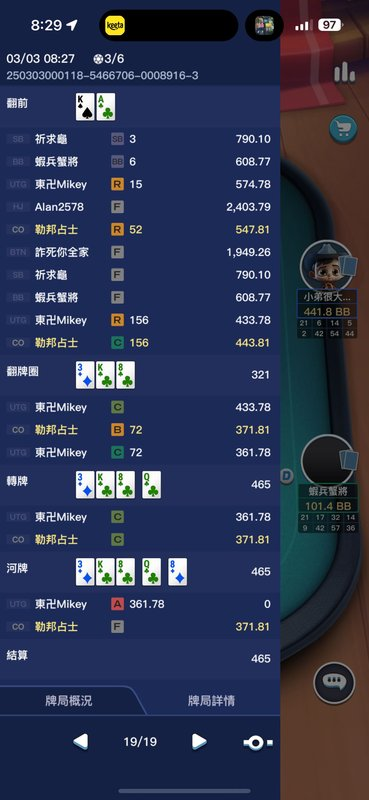

In [22]:
# Execute the agent to verify functionality
result = run_poker_agent()
print(result)

## Conclusion

In this notebook, we've created a poker analysis agent using LangGraph that can:
- Calculate hand strength using Monte Carlo simulations
- Provide strategic advice based on mathematical analysis
- Process poker hands from both text descriptions and optional images

The agent demonstrates how LangGraph enables the creation of sophisticated agents with domain-specific capabilities by combining LLMs with specialized tools.

Key improvements in this implementation:
1. Made image input optional, allowing the agent to work with or without visual data
2. Properly formatted user messages to handle the multi-modal content
3. Added robust testing to verify agent functionality
4. Created a comprehensive function to run the complete agent

This approach can be extended to other games or decision-making scenarios where probabilistic analysis informs strategic choices.